# Introduction

This notebook showcases the application of a linear logistic decoder to neural activity data recorded in freely behaving mice during competition against other mice. The model is used to decode:

<ol>
<li>Whether the animal is winning or losing</li>
<li>Whether the animal is in a competitive context, in other words, whether the mouse is competing or alone in its home environment</li>
<li>Individual bouts of competitive behaviors (e.g., pushing of the opponent, resisting, or retreating)</li>
</ol>

## The tube test
Activity is recorded during the tube test, a test of dominance relationships in mice, where two animals are inserted into a tube that is too narrow for turning, leading to one of the animals to push the other one out of the tube and winning the test. Annotated behaviours during this test are pushing, retreating, resisting the push of the opponent mouse.

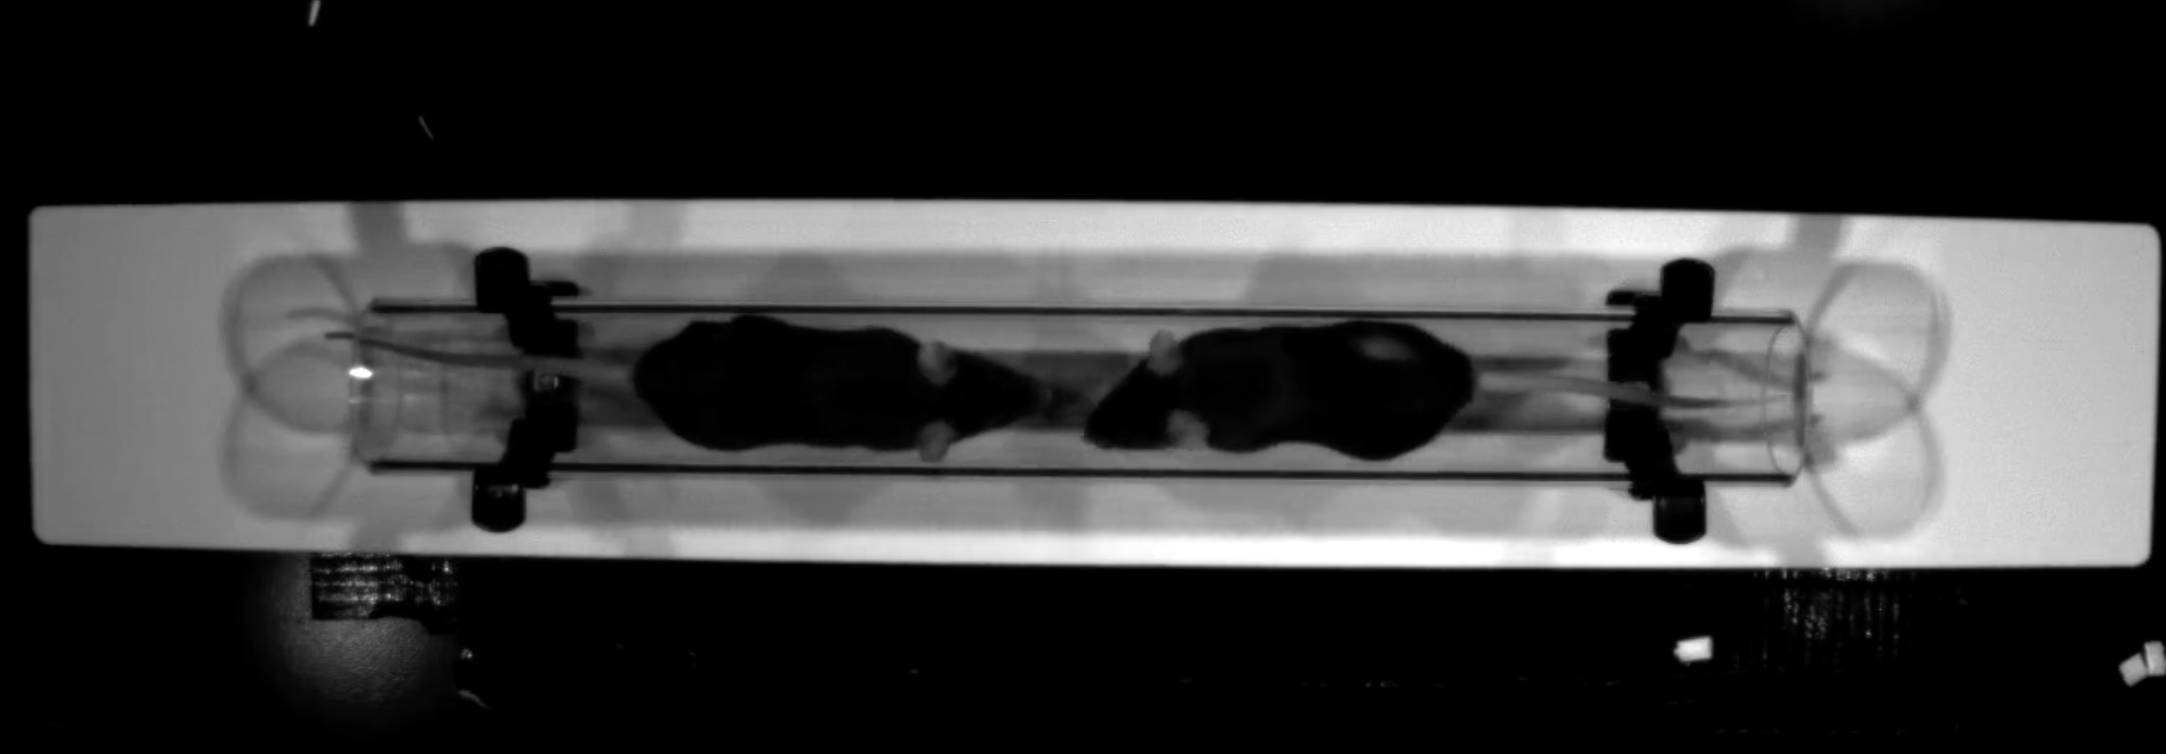

The activity was recorded from two brain areas in the mouse hypothalamus, the medial preoptic area (MPOA) and the ventromedial hypothalamus (VMH) using an implanted lens, which allows imaging of neuronal activity in vivo in cells expressing an optical indicator of cellular calcium concentration. 

__Example recording visualisation - red bars indicate tube tests, blue bars indicate first contact between the two mice__
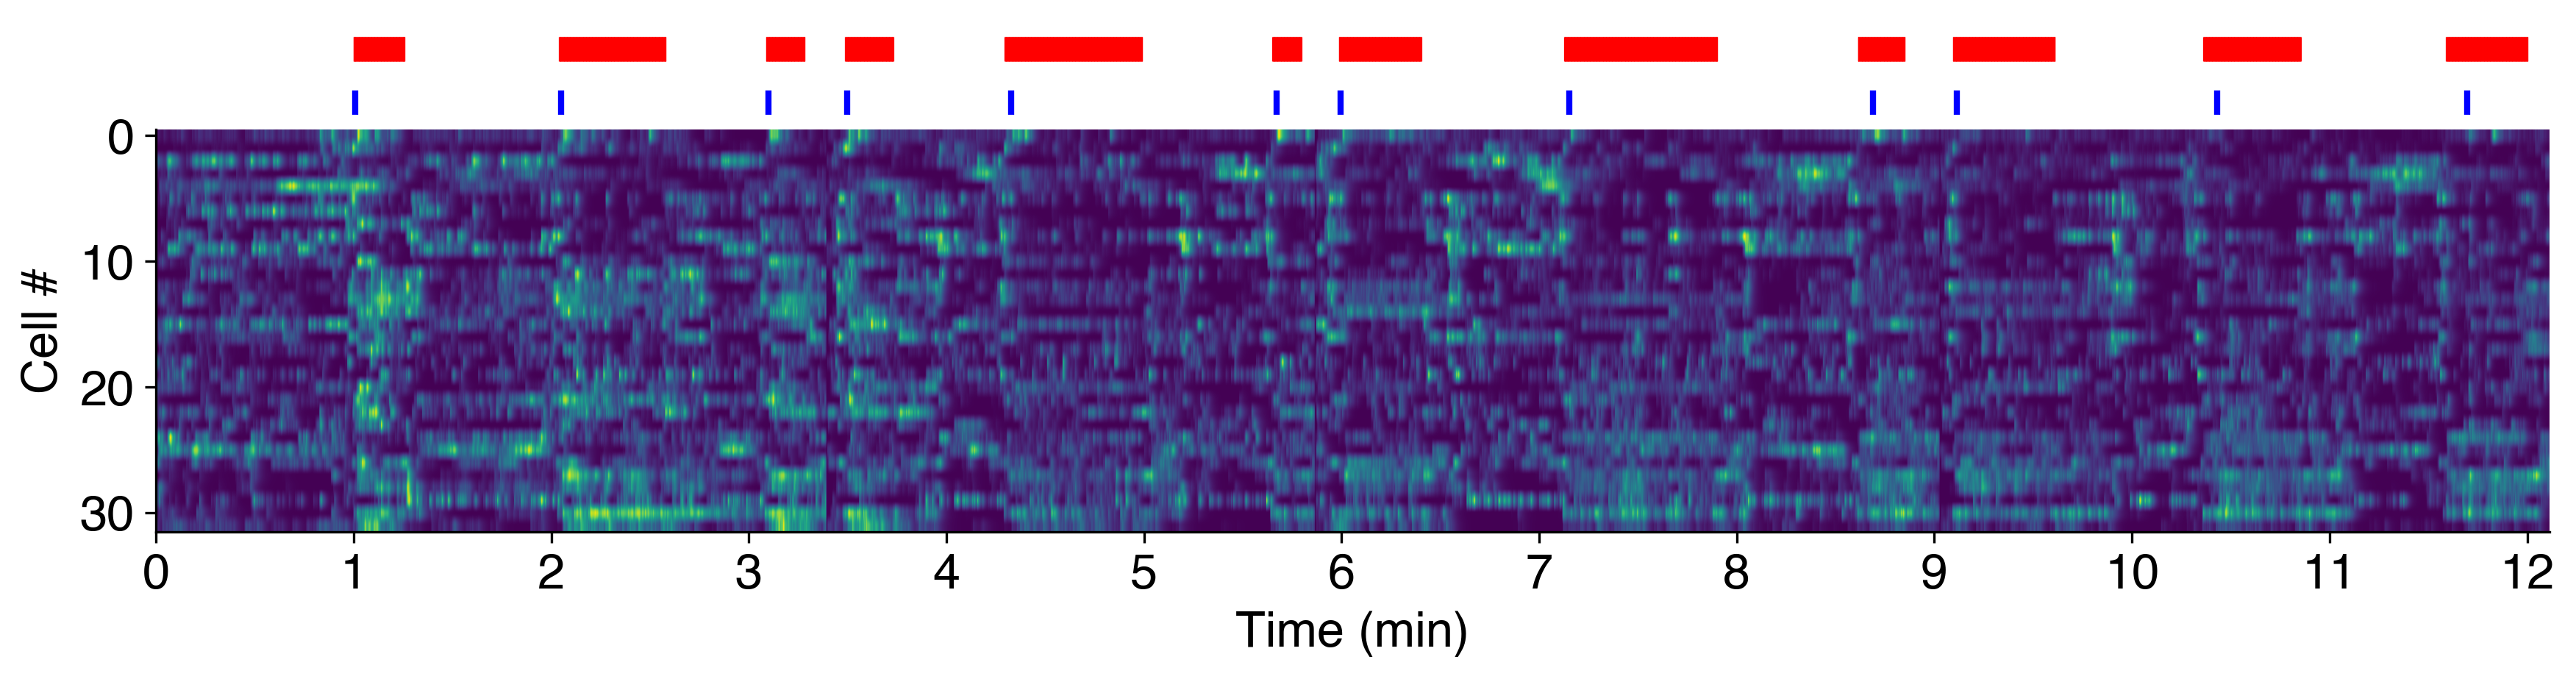

This notebook explores which variables related to competition in this test can be decoded from hypothalamic population activity.
The first two variables can be decoded significantly better compared to a model trained on shuffled labels, but not the third variable.

# Importing packages

In [7]:
import numpy as np
import pandas as pd

from snebeat import calcium_tools as ga
from snebeat import behav_tools as bat

from tqdm import tqdm
from glob import glob
from path import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import permutation_test_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Plot formatting

In [8]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Custom function definitions

In [75]:
def only_annotated(segments, bounds, require_first_contact = False):
    '''
    Removes tube test segments that don't have any behavioural annotations
    
    Args:
        - segments: a list of pandas dataframes, containing binary behavioural state arrays (each column is a different behaviour).
                    Each tube test segment has it's own dataframe.
        - bounds: a list of tuples, containing the start and end indices of each segment
        - require_first_contact; bool: specifies whether the first contact between the animals has to be annotated to be included in the
                                        output dataset.
                                        
    Returns:
        - retained_segments: same as segments but tube tests without behavioural annotations have been removed.
        - retained_bounds: same as bounds but tube tests without behavioural annotations have been removed.
    '''
    
    retained_segments = []
    retained_bounds = []
    for segment, bound in zip(segments, bounds):

        annotated = segment[['push', 'retreat']].sum().sum() > 0
        
        if require_first_contact:
            annotated = 'first contact' in bdf.columns
        
        if annotated:
            retained_segments.append(segment)
            retained_bounds.append(bound)
            
    return retained_segments, retained_bounds


def infer_TT_outcomes(segments, bounds):
    '''
    Compute if each tube test was won or lost based on behavioural annotations just before the end of the test
    and label every timepoint in the recording as belonging to a winning or losing trial.

    Args:
        - segments, pd.DataFrame:
        - bounds

    Returns:
        - wins, np.array: array of booleans indicating if each tube test was lost or won
        - outcomes, np.array: a boolean sequence indicating for each assay timepoint whether the tube test was won
    '''

    wins = []
    
    for segment in segments:
        pushes = np.where(segment.push)[0]
        retreats = np.where(segment.retreat)[0]

        if len(pushes) == 0:
            wins.append(False)
        elif len(retreats) == 0:
            wins.append(True)
        else:
            if pushes[-1] > retreats[-1]:
                wins.append(True)
            else:
                wins.append(False)

    wins = np.array(wins)

    outcomes = np.array([])
    for n, bound in enumerate(bounds):

        start, end = bound

        outcome = wins[n]

        outcome = np.ones((end + 1) - start) * outcome
        outcomes = np.append(outcomes, outcome)

    return wins, outcomes


def outcome_sequence_from_log(logpath, bounds):
    '''
    Load an external record of the outcomes of each test and creates a 1-dimensional array with a win/lose 
    label for each timepoint of the activity recording.
    '''
    log = pd.read_excel(logpath)
    wins = np.array(log.outcome)
    wins[wins == 'W'] = 1.
    wins[wins == 'L'] = 0.
    
    outcomes = np.array([])
    for n, bound in enumerate(bounds):

        start, end = bound

        outcome = wins[n]

        outcome = np.ones((end + 1) - start) * outcome
        outcomes = np.append(outcomes, outcome)

    return wins, outcomes


def bdf_to_sequence(bdf, behavs=['', 'push', 'resist', 'retreat']):
    '''
    Converts a dataframe of binary behavioural states (a column for each behaviour) into a 
    1-dimensional array with a behaviour label for each timepoint of the recording.
    
    Args:
        - bdf, pd.DataFrame: dataframe of ethograms for each behaviour
        - behavs: list of behaviours to include in the merged sequence

    Returns:
        - merged_bdf, np.array:
        - behavs: list of behaviours actually present in the dataset
    '''

    merged_bdf = np.zeros(bdf.shape[0], dtype='U25')

    for n, behav in enumerate(behavs):

        try:
            indices = np.where(bdf[behav] == 1)[0]
            merged_bdf[indices] = behav
        except KeyError:
            pass

    merged_bdf[merged_bdf == ''] = 'no behaviour'

    behavs = np.unique(merged_bdf)

    return merged_bdf, behavs

# Data loading and preprocessing

In [196]:
# finding the list of paths to the suitable recordings

sur_log = pd.read_excel('/Volumes/lab-kohlj/home/users/borakn/Data/Databases/GRIN surgery log.xlsx')
animals = np.logical_and(sur_log['Succeeded'], np.isin(sur_log['Site'], ['VMH', 'MPOA']))
animals = sur_log[['Cage', 'Mouse', 'Rank']][animals]
animals = animals['Cage'] + animals['Mouse'] + '_' + animals['Rank']
animals = animals.reset_index(drop=True)

recordings = [glob(f"{datapath/'Inscopix'/animal}*deconvolved_TT*.csv")[0] for animal in animals]

In [226]:
dfs = {}
segment_dfs = {}
context = {}
behaviour_states = {}
winning = {}

names = []

scaler = StandardScaler()
for recording in tqdm(recordings):
    
    recording_path = Path(recording)
    behaviour_path = datapath/'Behaviour/Inscopix'/''.join(recording_path.name.split('_deconvolved'))
    name = recording_path.name.split('_')[0]
    
    # Load the neural activity recording
    df = ga.load_inscopix(recording_path, normalisation=None)
    
    # Standardise the features (neuron signals) in the activity dataframe
    df = scaler.fit_transform(df.T)
    
    # Load the corresponding behavioural annotations
    try:
        _, bdf, _, _ = bat.preprocess_behaviour(behaviour_path, df.shape[0])
    except IndexError:
        # If the behaviour annotations have already been preprocessed into a dataframe, just load that directly
        bdf = pd.read_csv(behaviour_path)
        
    names.append(name)
    
    # Store data in a dictionary keyed by animal ID
    dfs[name] = df
    context[name] = bdf['tube test']
    
    ########################################################################################
    # The winning and behaviour decoders only use activity during competition periods. 
    # The code below segments the data, removes periods outside the tube test, and stores
    # the segmented datasets into dictionaries.
    
    segments, bounds = bat.segment(bdf, state_ref='tube test')

    # Find tube test outcomes
    if 'marathon' in recording:
        log = f"{log_path}/{recording}.xlsx"
        wins, outcomes = outcome_sequence_from_log(log, bounds)
    else:
        segments, bounds = only_annotated(segments, bounds)
        wins, outcomes = infer_TT_outcomes(segments, bounds)
        
    # Make sure there is at least one winning and one losing segment, otherwise remove the dataset
    if len(np.unique(outcomes)) < 2:
        continue

    # Format the remaining tube test segments into a single behavioural sequence
    segment_bdf = pd.concat(segments).reset_index(drop=True)
    linearised_bdf, _ = bdf_to_sequence(segment_bdf, ['','push', 'resist', 'retreat'])

    # Index the activity dataset based on the selected tube test segments
    segmented_activity = ga.segment_calcium_recording(df.T, bounds).T
    
    # Store segmented data in dictionaries
    segment_dfs[name] = segmented_activity
    behaviour_states[name] = linearised_bdf
    winning[name] = outcomes
    

100%|███████████████████████████████████████████| 18/18 [00:09<00:00,  1.84it/s]


# Model fitting

## Hyperparameters

In [297]:
k = 5                                                    # Number of cross-validation folds
cv = StratifiedKFold(n_splits=k, shuffle=False)          # sk-learn data splitter for cross-validation
scoring = 'f1_weighted'                                  # Evaluation metric for model performance
penalty = 'l2'                                           # Regularisation penalty type (l1 or l2)
C = 1                                                    # Regularisation coefficient
decoded_variable = 'TT_outcome'                          # "context", "behaviour", or "TT_outcome"

## Model fitting

In [251]:
results = {}

In [298]:
# Determines the activity dataset and Y dataset with sample labels to use
# Based on the variable being decoded
if decoded_variable == 'context':
    X_data = dfs
    Y_data = context
elif decoded_variable == 'behaviour':
    X_data = segment_dfs
    Y_data = behaviour_states
elif decoded_variable == 'TT_outcome':
    X_data = segment_dfs
    Y_data = winning
    
names = X_data.keys()

reals = []
shuffles = []
# Fit a model for each animal and perform a permutation test to obtain the real model performance 
# and performance on shuffled labels
for name in tqdm(names):
    X = X_data[name]
    Y = Y_data[name]
    model = LogisticRegression(solver='liblinear', C=C, penalty=penalty)
    real, shuffle, _ = permutation_test_score(model, X, Y, cv=cv, scoring='f1_weighted', n_jobs=-1)
    
    reals.append(real)
    shuffles.append(np.mean(shuffle))
    
# Result dataframe formatting
performance = pd.DataFrame(np.stack([[*names], reals, shuffles]).T, columns=['name', 'real', 'shuffle'])

sur_log['name'] = sur_log.Cage + sur_log.Mouse
performance = performance.merge(sur_log[['name', 'Site', 'Rank']], how='left')
performance = pd.melt(performance, id_vars=['name', 'Site', 'Rank'], value_name='perf', var_name='condition')
performance.perf = performance.perf.astype(float)

results[decoded_variable] = performance

100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.40it/s]


# Performance Visualisation

In [309]:
def plot_performance(performance_df, legend=False, title=None):
    '''
    Plots the paired true and shuffled performances of decoders trained on each animal.
    
    Args:
        - performance_df: pandas dataframe with decoder performances
        - legend; bool: specifies whether to show the hue legend
        - title; str: optionally specified plot title
    '''
    
    for name, animal in performance_df.groupby('name'):
        sns.lineplot(data=animal, x='condition', y='perf', color='black')
    
    sns.scatterplot(performance_df, x='condition', y='perf', hue='Site', hue_order=['VMH', 'MPOA'], s=[50])

    plt.ylabel('Weighted F1 score')
    plt.xlabel('')
    plt.xticks([0,1], ['Real', 'Shuffled'], rotation=90)

    plt.xlim(-0.3,1.3)
    
    if legend:
        plt.legend(loc=[1, 0.8], prop={'size': 10}, frameon=False)
    else:
        plt.legend('', frameon=False)
        
    if title is not None:
        plt.title(title, fontsize=12, pad=20)
    
    # Statistics
    model = smf.ols('perf ~ condition + Site + name', performance_df).fit()
    
    p = model.pvalues['condition[T.shuffle]']
    sig_label = ['n.s.', '*', '**', '***', '****'][(p < [0.05, 0.01, 0.001, 0.0001]).sum()]
    if sig_label == 'n.s.':
        fontsize = 16
    else:
        fontsize = 25
    plt.text(0.35, performance_df.perf.max(), sig_label, fontsize=fontsize)

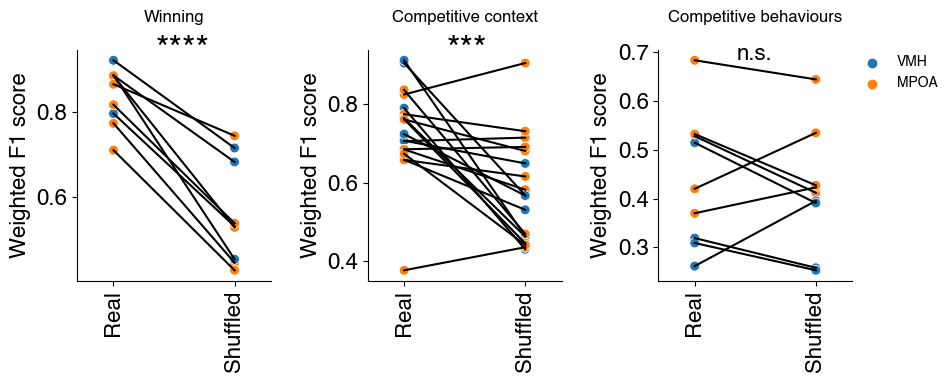

In [310]:
titles = {'TT_outcome': 'Winning',
          'context': 'Competitive context',
          'behaviour': 'Competitive behaviours',}

plt.figure(figsize=[10,3])
plt.subplots_adjust(wspace=0.5)

for n, decoded_variable in enumerate(['TT_outcome', 'context', 'behaviour']):
    plt.subplot(1, 3, n+1)
    
    if n==2:
        legend = True
    else:
        legend = False 

    plot_performance(results[decoded_variable], legend, title = titles[decoded_variable])

## Example predictions

### Winning

In [429]:
# Fits a model on an example recording and generates the continuous probability that the animal is winning a tube test

mouse_id = 'C00601308B'

X_data = segment_dfs
Y_data = winning

X = X_data[mouse_id]
Y = Y_data[mouse_id]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

model = LogisticRegression(solver='liblinear', C=C, penalty=penalty)
shuffle_model = LogisticRegression(solver='liblinear', C=C, penalty=penalty)

model.fit(X_train, y_train)
shuffle_model = shuffle_model.fit(X, np.random.permutation(Y))

probability = model.predict_proba(X)[:,1]
shuffled_probability = shuffle_model.predict_proba(X)[:, 1]

Text(0, 0.5, 'Winning probability')

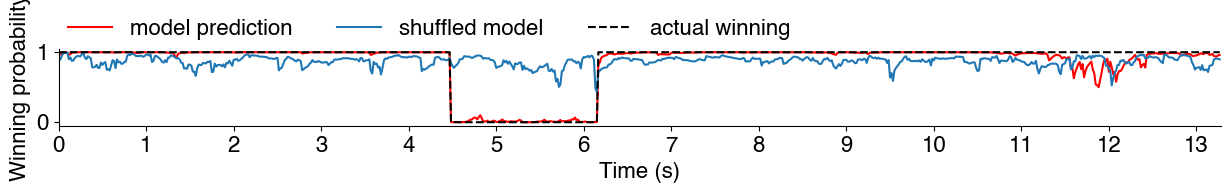

In [431]:
plt.figure(figsize=[15,1])

plt.plot(probability, color='red', label='model prediction')
plt.plot(shuffled_probability, label='shuffled model')
plt.plot(np.array(Y), color='black', linestyle='--', label='actual winning')

plt.xlim(0,len(probability))
plt.legend(frameon=False, ncols=3, loc=[0, 1])

plt.xticks(np.arange(0, len(probability), 60), np.arange(len(probability) / 60).astype(int))
plt.xlabel('Time (s)')

plt.ylabel('Winning probability')

### Tube test context

In [433]:
# Fits a model on an example recording and generates the continuous probability that the animal is in a tube test

mouse_id = 'C00578098B'

X_data = dfs
Y_data = context

X = X_data[mouse_id]
Y = Y_data[mouse_id]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

model = LogisticRegression(solver='liblinear', C=C, penalty=penalty)
shuffle_model = LogisticRegression(solver='liblinear', C=C, penalty=penalty)

model.fit(X_train, y_train)
shuffle_model = shuffle_model.fit(X, np.random.permutation(Y))

probability = model.predict_proba(X)[:,1]
shuffled_probability = shuffle_model.predict_proba(X)[:, 1]

Text(0, 0.5, 'Probability')

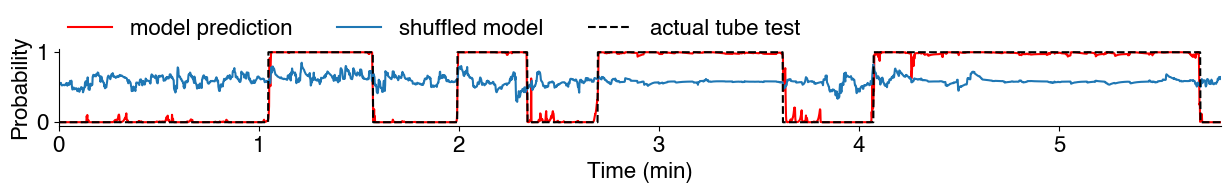

In [434]:
# Visualisation

plt.figure(figsize=[15,1])

plt.plot(probability, color='red', label='model prediction')
plt.plot(shuffled_probability, label='shuffled model')
plt.plot(np.array(Y), color='black', linestyle='--', label='actual tube test')

plt.xlim(0,len(probability))
plt.legend(frameon=False, ncols=3, loc=[0, 1])

plt.xticks(np.arange(0, len(probability), 600), np.arange(len(probability) / 600).astype(int))
plt.xlabel('Time (min)')

plt.ylabel('Probability')